# Melanoma_Detection_Assignment 


**Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis. Build a multiclass classification model using a custom convolutional neural network in TensorFlow. 

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion Vascular lesion

## Solution Plan:

- Data Reading/Data Understanding
- Dataset Creation
- Dataset visualisation
- Model Building & training
- Chose an appropriate data augmentation strategy to resolve underfitting/overfitting
- Model Building & training on the augmented data
- Class distribution
- Handling class imbalances: with Augmentor[https://augmentor.readthedocs.io/en/master/] library.
- Model Building & training on the rectified class imbalance data


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.regularizers import l2

model = models.Sequential

import pathlib
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Data and Pre-process it

In [2]:
batch_size = 32
epochs = 20
input_image_height = 180
input_image_width = 180

training_data_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
testing_data_dir = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

In [3]:
data_dir_train = pathlib.Path(training_data_dir)
data_dir_test  = pathlib.Path(testing_data_dir)

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Total images in training directory:", image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Total images in testing directory:", image_count_test)

Total images in training directory: 2239
Total images in testing directory: 118


In [4]:
?tf.keras.preprocessing.image_dataset_from_directory

Signature:
tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Docstring:
Generates a `tf.data.Dataset` from image files in a directory.

If your directory structure is:

```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```

Then calling `image_dataset_from_directory(main_directory,
labels='inferred')` will return a `tf.data.Dataset` that yields batches of
images from the subdirectories `class_a` and `class_b`, together with labels
0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`).

Supported image formats: jpeg, png, bmp, gif.
Animated gifs are truncated to the firs

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='training',
    #label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    training_data_dir,
    labels='inferred', seed=123,
    validation_split=0.2,
    subset='validation',
    #label_mode='categorical',
    image_size=(input_image_height, input_image_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [6]:
#print('Image per batch:', len(list(train_ds.as_numpy_iterator())))
print('Images in Train:', len(train_ds.file_paths))
print('Images in Validation:', len(val_ds.file_paths))

Images in Train: 1792
Images in Validation: 447


In [7]:
class_names = train_ds.class_names
print('The Class Names are: ', class_names)

The Class Names are:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 2. Visualization of Data

In [8]:
for img, lab in train_ds:
    print(lab)

tf.Tensor([8 4 5 5 3 2 5 0 1 5 7 4 0 4 7 3 3 5 1 5 3 1 1 1 0 1 5 4 2 7 4 1], shape=(32,), dtype=int32)
tf.Tensor([4 6 3 4 4 5 4 0 6 6 3 1 4 8 5 1 5 5 1 5 4 5 6 0 5 4 4 5 5 4 4 5], shape=(32,), dtype=int32)
tf.Tensor([3 4 5 3 7 3 3 3 4 4 4 3 4 3 8 3 4 4 1 3 4 3 5 3 0 7 3 4 3 4 3 5], shape=(32,), dtype=int32)
tf.Tensor([3 5 5 3 5 2 5 5 5 4 3 4 3 1 3 3 0 3 1 1 5 5 3 7 8 4 5 5 8 6 5 4], shape=(32,), dtype=int32)
tf.Tensor([4 3 3 3 3 2 7 3 7 5 3 4 1 5 0 4 2 3 4 3 5 1 5 1 2 3 3 4 2 4 3 4], shape=(32,), dtype=int32)
tf.Tensor([5 3 1 5 3 7 2 5 1 5 7 8 3 2 5 8 6 7 3 3 4 5 4 3 1 3 3 3 7 3 3 5], shape=(32,), dtype=int32)
tf.Tensor([4 4 3 5 8 3 5 1 3 4 3 3 1 1 5 3 3 5 3 1 0 3 6 5 7 7 1 3 5 1 5 3], shape=(32,), dtype=int32)
tf.Tensor([5 1 1 4 7 5 5 2 4 0 3 7 5 4 3 7 1 3 1 1 3 5 5 3 3 8 2 2 5 1 8 4], shape=(32,), dtype=int32)
tf.Tensor([3 0 4 5 4 5 3 1 4 3 4 5 3 5 8 6 4 1 1 4 5 5 3 5 3 5 3 0 5 5 3 7], shape=(32,), dtype=int32)
tf.Tensor([0 3 5 3 3 1 3 1 4 8 2 1 3 3 7 0 1 7 5 1 5 5 4 7 2 1 5 7 8 8 7 

fig = plt.figure(figsize=(9,9))

for i in range(len(class_names)): #class_names: #
#for each_class in class_names: #
   #filtered_ds = train_ds.filter(lambda img, label: tf.math.equal(label[0], i))
   filtered_ds = train_ds.filter(lambda img, label: tf.math.equal(label[0], i))
   #filtered_ds = train_ds.filter(lambda img, label: tf.math.equal(label[0] , class_names.index(each_class)))
   for image, label in filtered_ds.take(-1):
       ax = plt.subplot(3, 3, i+1)
       plt.imshow(image[0].numpy().astype('uint8'))
       plt.title(class_names[label.numpy()[0]])
       plt.axis('off')

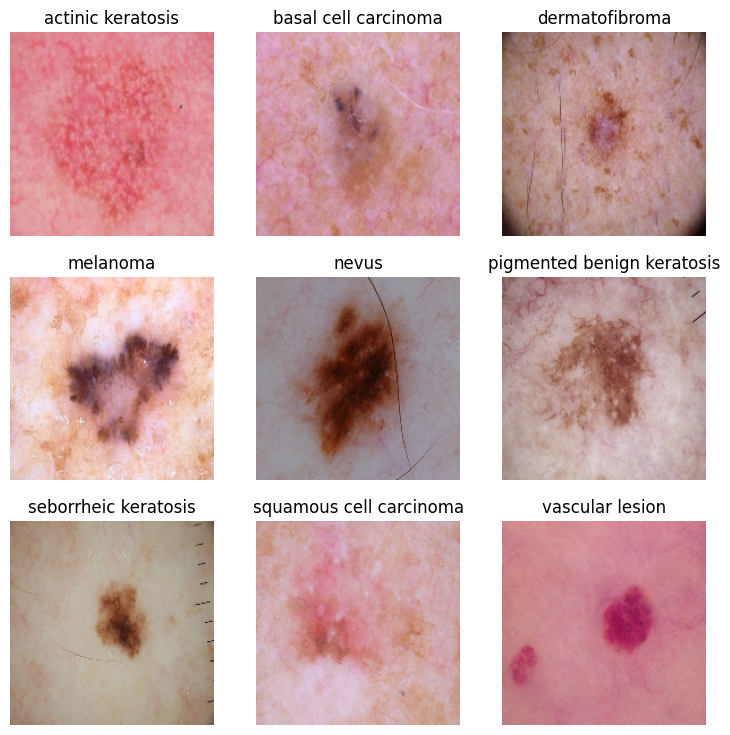

In [18]:
fig = plt.figure(figsize=(9,9))

for i in range(len(class_names)):
   filtered_ds = train_ds.filter(lambda img, label: tf.math.equal(label[0], i))
   for image, label in filtered_ds.take(-1):
       ax = plt.subplot(3, 3, i+1)
       plt.imshow(image[0].numpy().astype('uint8'))
       plt.title(class_names[label.numpy()[0]])
       plt.axis('off')

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
class_names.index('actinic keratosis')

0

## 3. Create the model

In [12]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [13]:
model = keras.Sequential()
#model.add(keras.layers.Rescaling(1./255))
model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))

#Convolution with 32 filters
model.add(layers.Conv2D(32, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model.add(Dropout(0.25))


#Convolution with 64 filters
model.add(layers.Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(1,1)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names)))
model.add(Activation('softmax'))

In [14]:
model.build(train_ds.as_numpy_iterator().next()[0].shape)

In [15]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (32, 180, 180, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (32, 180, 180, 32)        9248      
                                                                 
 activation (Activation)     (32, 180, 180, 32)        0         
                                                                 
 batch_normalization (Batch  (32, 180, 180, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (32, 179, 179, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 179, 179, 32)        0

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
model.fit(train_ds, epochs = epochs,validation_data=val_ds)

Epoch 1/20


ValueError: in user code:

    File "C:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Program Files\Python39\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 2122, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Program Files\Python39\lib\site-packages\keras\src\backend.py", line 5560, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 9) are incompatible


In [ ]:
epochs

In [ ]:
model.fit(x_train, y_train,
             batch_size = batch_size,
             epochs = epochs,
             validation_data=(x_test, y_test),
             shuffle=True)

In [ ]:
#fig = plt.figure(figsize=(9,9))
#
#for each_class in range(len(class_names)):
#    fig_path = [x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, class_names[each_class]))][0]
#    #print(fig_path)
#    ax = plt.subplot(3, 3, each_class+1)
#
#    plt.imshow(cv2.imread(fig_path))
#    plt.title(class_names[each_class])
#    plt.axis("off")
#plt.show()

In [ ]:
#class_names = train_ds.class_names
#fig = plt.figure(figsize=(8,3))
#
#for i in range(len(class_names)):
#    ax = fig.add_subplot(2,5,1+i, xticks=[], yticks=[])
#    im = train_ds[i]
#    plt.imshow(im)
#plt.show()

In [ ]:
#?train_ds.take

In [ ]:
#?train_ds.as_numpy_iterator

In [ ]:
#?tf.keras.utils.image_dataset_from_directory

In [ ]:
#[[x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, c))][0] for c in class_names]

In [ ]:
#for images, labels in train_ds.map(lambda x, y: (x, y)):
#    #for l in labels:
#    #    print(l)
#    conc_labels = labels[0]+labels[1]
#    numpy_data = conc_labels.numpy()
#    if(numpy_data == 1):
#        print(numpy_data)
#    #print(conc_labels.lambda(x: x.numpy()==1))
#    #numpy_data.numpy()

In [ ]:
#train_ds.map(lambda x, y: (x, y)).list_files()

In [ ]:
#?train_ds.map #.get_single_element

In [ ]:
#plt.figure(figsize = (10,10))
#for images, labels in train_ds.take(1):
#    for i in range(9):
#        ax = plt.subplot(3,3,i+1)
#        plt.imshow(images[i].numpy().astype("uint8"))
#        plt.title(class_names[labels[i]])
#        plt.axis("off")

In [ ]:
#?train_ds.take

In [ ]:
tf.compat.v1.data.experimental.get_single_element(train_ds)

In [ ]:
#[[x for x in train_ds.file_paths if x.startswith("{0}{1}".format(training_data_dir, c))][0] for c in class_names]

In [ ]:
train_ds.as_numpy_iterator().next()[0].shape